In [1]:
# ==========================================================
# Stock Next-Day Close Prediction
# ==========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

import joblib


In [2]:
# ==========================================================
# 1) Data Loading (Last 5 Years)
# ==========================================================

ticker = "TCS.NS"
period = "5y"  # exactly 10 years for efficiency

df = yf.download(ticker, period=period, interval="1d", auto_adjust=False)
df.dropna(inplace=True)

print("Ticker:", ticker)
print("Date Range:", df.index.min().date(), "to", df.index.max().date())
print("Shape:", df.shape)

df.head()


[*********************100%***********************]  1 of 1 completed

Ticker: TCS.NS
Date Range: 2021-01-21 to 2026-01-21
Shape: (1239, 6)


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS
Date,,,,,,
2021-01-21,2877.966064,3273.850098,3309.149902,3262.100098,3305.000000,2778546
2021-01-22,2903.679443,3303.100098,3325.000000,3241.899902,3241.899902,3052459
2021-01-25,2893.305664,3291.300049,3339.800049,3278.649902,3308.949951,2272887
2021-01-27,2866.713867,3261.050049,3306.449951,3227.000000,3300.000000,2786662
2021-01-28,2810.013428,3196.550049,3275.000000,3183.800049,3230.000000,3083938


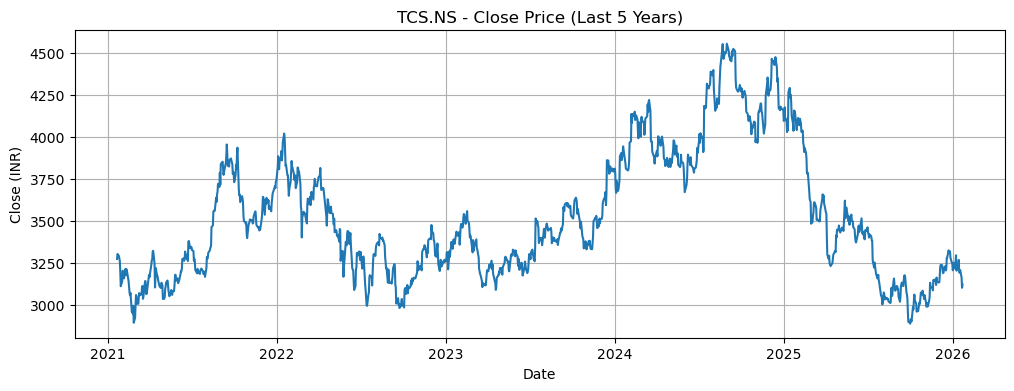

In [3]:
# ==========================================================
# 2) Data Visualization (Close Trend)
# ==========================================================

plt.figure(figsize=(12, 4))
plt.plot(df["Close"])
plt.title(f'{ticker} - Close Price (Last 5 Years)')
plt.xlabel("Date")
plt.ylabel("Close (INR)")
plt.grid(True)
plt.show()


In [4]:
# ==========================================================
# 3) Feature Engineering
# ==========================================================

data = df.copy()

# Basic derived features
data["Return_1d"] = data["Close"].pct_change()
data["HL_Range"] = data["High"] - data["Low"]
data["OC_Range"] = data["Open"] - data["Close"]

# Rolling statistics (trend + volatility)
for w in [5, 10, 20]:
    data[f"SMA_{w}"] = data["Close"].rolling(window=w).mean()
    data[f"STD_{w}"] = data["Close"].rolling(window=w).std()

# Lag features (memory)
for lag in [1, 2, 3, 5, 10]:
    data[f"Close_Lag_{lag}"] = data["Close"].shift(lag)
    data[f"Return_Lag_{lag}"] = data["Return_1d"].shift(lag)

# Target: Next-day close price
data["Target_Close_Next"] = data["Close"].shift(-1)

# Drop rows with NaNs caused by rolling/lags/shift
data.dropna(inplace=True)

data.head()


Price,Adj Close,Close,High,Low,Open,Volume,Return_1d,HL_Range,OC_Range,SMA_5,...,Return_Lag_1,Close_Lag_2,Return_Lag_2,Close_Lag_3,Return_Lag_3,Close_Lag_5,Return_Lag_5,Close_Lag_10,Return_Lag_10,Target_Close_Next
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-18,2687.645752,3057.350098,3097.899902,3031.000000,3065.0,4189909,-0.005125,66.899902,7.649902,3113.980078,...,-0.011484,3108.800049,-0.009889,3139.850098,-0.015968,3206.000000,-0.002272,3188.449951,-0.003625,3071.850098
2021-02-19,2700.392090,3071.850098,3087.149902,3016.149902,3058.0,3725028,0.004743,71.000000,-13.850098,3090.190088,...,-0.005125,3073.100098,-0.011484,3108.800049,-0.009889,3190.800049,-0.004741,3157.949951,-0.009566,2958.449951
2021-02-22,2600.704834,2958.449951,3096.000000,2943.149902,3096.0,5366696,-0.036916,152.850098,137.550049,3053.910059,...,0.004743,3057.350098,-0.005125,3073.100098,-0.011484,3139.850098,-0.015968,3214.100098,0.017781,2980.199951
2021-02-23,2619.825439,2980.199951,3028.000000,2968.000000,2970.0,3832829,0.007352,60.000000,-10.199951,3028.190039,...,-0.036916,3071.850098,0.004743,3057.350098,-0.005125,3108.800049,-0.009889,3176.899902,-0.011574,2948.100098
2021-02-24,2591.606689,2948.100098,3003.350098,2921.149902,2972.0,3774549,-0.010771,82.200195,23.899902,3003.190039,...,0.007352,2958.449951,-0.036916,3071.850098,0.004743,3073.100098,-0.011484,3213.300049,0.011458,2995.300049


In [5]:
# ==========================================================
# 4) Time-Series Train/Test Split (No Shuffle)
# ==========================================================

feature_cols = [
    "Return_1d", "HL_Range", "OC_Range",
    "SMA_5", "SMA_10", "SMA_20",
    "STD_5", "STD_10", "STD_20",
    "Close_Lag_1", "Close_Lag_2", "Close_Lag_3", "Close_Lag_5", "Close_Lag_10",
    "Return_Lag_1", "Return_Lag_2", "Return_Lag_3", "Return_Lag_5", "Return_Lag_10"
]

X = data[feature_cols]
y = data["Target_Close_Next"]

split_idx = int(len(data) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (975, 19) Test size: (244, 19)


In [6]:
# ==========================================================
# 5) Model Training (XGBoost Regressor)
# ==========================================================

model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    objective="reg:squarederror"
)

model.fit(X_train, y_train)

pred = model.predict(X_test)


In [7]:
# ==========================================================
# 6) Model Evaluation
# ==========================================================

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("MAE :", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("R²  :", round(r2, 4))


MAE : 39.014
RMSE: 52.121
R²  : 0.9616


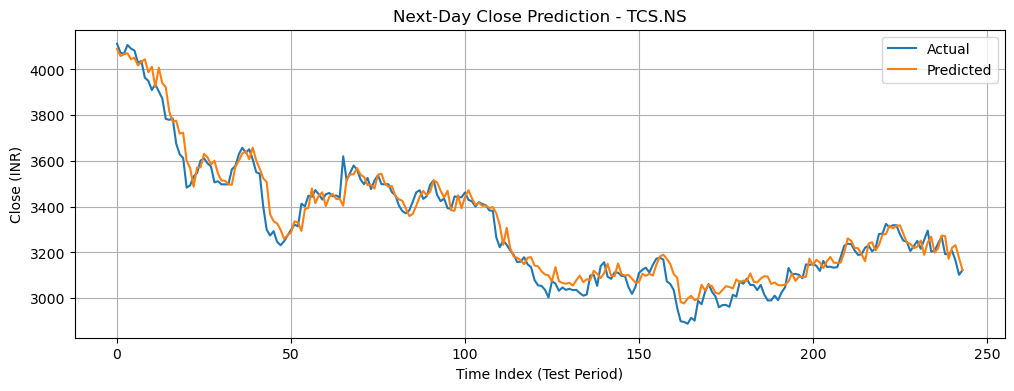

In [8]:
# ==========================================================
# 7) Visualization: Actual vs Predicted
# ==========================================================

plt.figure(figsize=(12, 4))
plt.plot(y_test.values, label="Actual")
plt.plot(pred, label="Predicted")
plt.title(f'Next-Day Close Prediction - {ticker}')
plt.xlabel("Time Index (Test Period)")
plt.ylabel("Close (INR)")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# ==========================================================
# 9) Predict Next Day Close (Latest Available Row)
# ==========================================================

latest_features = X.iloc[-1].values.reshape(1, -1)
next_close_prediction = model.predict(latest_features)[0]

print("Latest Close:", round(data['Close'].iloc[-1], 2))
print("Predicted Next Close: INR", round(next_close_prediction, 2))


Latest Close: Ticker
TCS.NS    3102.3
Name: 2026-01-20 00:00:00, dtype: float64
Predicted Next Close: INR 3123.2


In [10]:
# ==========================================================
# Save Model + Feature Columns (PKL)
# ==========================================================

import joblib

# Save the trained model
joblib.dump(model, "stock_xgb_model.pkl")

# Save feature columns (important for consistent prediction later)
joblib.dump(feature_cols, "stock_feature_cols.pkl")

print("Saved files:")
print("stock_xgb_model.pkl")
print("stock_feature_cols.pkl")


Saved files:
stock_xgb_model.pkl
stock_feature_cols.pkl


**Notes**
---
This model generates a short horizon estimate based on historical price patterns. Market movement is uncertain, so the forecast should be treated as a probabilistic signal and not a guaranteed outcome.